# Обработка фотографий покупателя

## Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 



In [4]:


df = pd.read_csv('/datasets/faces/labels.csv')
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В данных 7591 строка

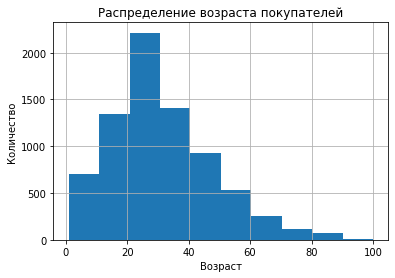

In [3]:
df['real_age'].hist()
plt.title('Распределение возраста покупателей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Возраст покупателей распределен близко к нормальному, больше всего фотографий людей 15-40 лет

In [4]:

df.head(13)



,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


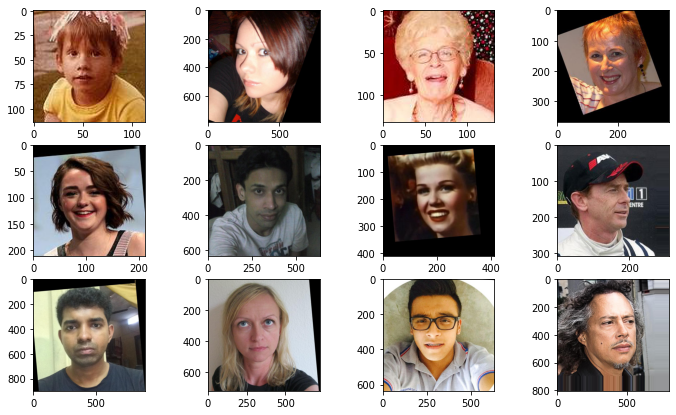

In [5]:
def printy(foto):
    image = Image.open(foto)
    array = np.array(image)
    return plt.imshow(array)
plt.figure(figsize=(12, 7))
plt.subplot(3, 4, 1)
printy('/datasets/faces/final_files/000000.jpg')
plt.subplot(3, 4, 2)
printy('/datasets/faces/final_files/000001.jpg')
plt.subplot(3, 4, 3)
printy('/datasets/faces/final_files/000002.jpg')
plt.subplot(3, 4, 4)
printy('/datasets/faces/final_files/000003.jpg')
plt.subplot(3, 4, 5)
printy('/datasets/faces/final_files/000004.jpg')
plt.subplot(3, 4, 6)
printy('/datasets/faces/final_files/000005.jpg')
plt.subplot(3, 4, 7)
printy('/datasets/faces/final_files/000006.jpg')
plt.subplot(3, 4, 8)
printy('/datasets/faces/final_files/000007.jpg')
plt.subplot(3, 4, 9)
printy('/datasets/faces/final_files/000008.jpg')
plt.subplot(3, 4, 10)
printy('/datasets/faces/final_files/000009.jpg')
plt.subplot(3, 4, 11)
printy('/datasets/faces/final_files/000010.jpg')
plt.subplot(3, 4, 12)
printy('/datasets/faces/final_files/000011.jpg');



В таблице в каждой строке наименование фотографии и возраст человека на фотографии. Папка /datasets/faces/final_files/ содержит указанные фотографии.

/opt/conda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 7591 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames.


IndexError: index 0 is out of bounds for axis 0 with size 0

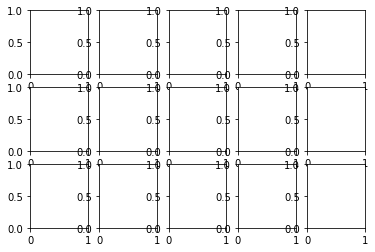

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

data_flow = datagen.flow_from_dataframe(
                    dataframe=df,
                    x_col='file_name',
                    y_col='real_age',
                    batch_size=16,
                    class_mode='raw',
                    seed=12)

feature, label = next(data_flow)

fig, axes = plt.subplots(nrows=3, ncols=5)

for i, ax in enumerate(axes.flat):
    ax.imshow(feature[i])
    ax.set_title(label[i])

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
optimizer = Adam(lr=0.0001) 
model = ResNet50(input_shape=None,
                 classes=1000,
                 include_top=True,
                 weights='imagenet') 
 
 
def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
    train_datagen = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen

def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
    test_datagen = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen
 
 
def create_model(input_shape):
      backbone = ResNet50(input_shape=(224,224,3),
                    weights='imagenet', 
                    include_top=False)
      model = Sequential()
      model.add(backbone)
      model.add(GlobalAveragePooling2D())
      model.add(Dense(64, input_dim=4, activation='relu')),
      model.add(Dense(32, activation='relu')),
      model.add(Dense(1))
      model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error'])
      return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-05-14 05:58:36.117362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-14 05:58:38.376113: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 69s - loss: 266.6066 - mean_absolute_error: 11.6977 - val_loss: 665.7027 - val_mean_absolute_error: 20.8144
Epoch 2/10
178/178 - 37s - loss: 59.3066 - mean_absolute_error: 5.8083 - val_loss: 653.0111 - val_mean_absolute_error: 20.3310
Epoch 3/10
178/178 - 37s - loss: 30.2755 - mean_absolute_error: 4.2449 - val_loss: 223.5688 - val_mean_absolute_error: 11.8391
Epoch 4/10
178/178 - 37s - loss: 18.5088 - mean_absolute_error: 3.3215 - val_loss: 113.2398 - val_mean_absolute_error: 8.1012
Epoch 5/10
178/178 - 37s - loss: 13.5406 - mean_absolute_error: 2.8523 - val_loss: 78.1818 - val_mean_absolute_error: 6.7506
Epoch 6/10
178/178 - 37s - loss: 10.9083 - mean_absolute_error: 2.5453 - val_loss: 78.0272 - val_mean_absolute_error: 6.5718
Epoch 7/10
178/178 - 37s - loss: 8.8602 - mean_absolute_error: 2.2589 - val_loss: 70.0686 - val_mean_absolute_error: 6.2636
Epoch 8/10
178/178 - 39s - loss: 7.8938 - mean_absolute_error: 2.1285 - val_loss: 70.0077 - val_mean_absolute_error: 6.4304
Epoch 9/10
178/178 - 39s - loss: 7.2867 - mean_absolute_error: 2.0265 - val_loss: 66.2593 - val_mean_absolute_error: 6.0912
Epoch 10/10
178/178 - 39s - loss: 6.6766 - mean_absolute_error: 1.9325 - val_loss: 66.6896 - val_mean_absolute_error: 6.1389
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 66.6896 - mean_absolute_error: 6.1389
Test MAE: 6.1389




```

MAE падает с каждой эпохой с небольшой погрешностью

## Анализ обученной модели

 ### MAE падает с каждой эпохой с небольшой погрешностью
 ### Лучший результат МАЕ 6.1389 показала модель ResNet50 с 10 эпохами lr=0.0001
 ### Улучшить качество модели можно, уменьшив learning rate оптимизатора Adam и увеличив количество эпох